In [1]:
!pip install networkx
!pip install Qiskit
!pip install qiskit_nature
!pip install qiskit_ignis
!pip install qiskit-ibm-runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import  QuantumCircuit, QuantumRegister, transpile,IBMQ
from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I,Y


from qiskit_ibm_runtime import QiskitRuntimeService, Session,Estimator,Sampler
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit_aer.noise import NoiseModel


import util1

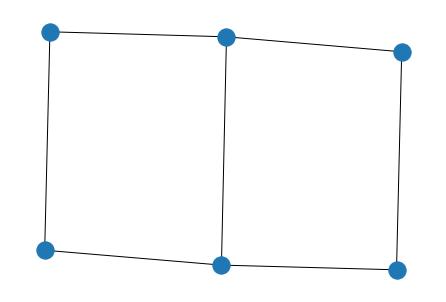

In [3]:
g = nx.Graph()
 
g.add_edge(0, 1)
g.add_edge(1, 3)
g.add_edge(0, 2)
g.add_edge(2, 3)
g.add_edge(2, 4)
g.add_edge(3, 5)
g.add_edge(4, 5)
 
nx.draw(g)
plt.show()

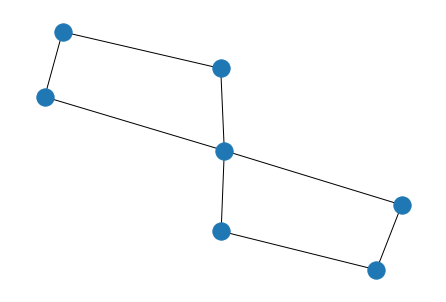

In [4]:
g_edge_OBC = nx.Graph()
 
g_edge_OBC.add_edge(0, 1)
g_edge_OBC.add_edge(1, 2)
g_edge_OBC.add_edge(0, 3)
g_edge_OBC.add_edge(2, 3)
g_edge_OBC.add_edge(2, 4)
g_edge_OBC.add_edge(6, 5)
g_edge_OBC.add_edge(4, 5)
g_edge_OBC.add_edge(6, 2)
 
nx.draw(g_edge_OBC)
plt.show()

In [5]:
def Hamiltonian_OBC(g,h):
  X1 = Z^Z^Z^Z^I^I^I
  X2 = I^I^I^Z^Z^Z^Z
  Z1 = X^I^I^I^I^I^I
  Z2 = I^X^I^I^I^I^I
  Z3 = I^I^X^I^I^I^I
  Z4 = I^I^I^X^I^I^I
  Z5 = I^I^I^I^X^I^I
  Z6 = I^I^I^I^I^X^I
  Z7 = I^I^I^I^I^I^X

  H=(h*X1) + \
    (h*X2) + \
    (g*Z1) + \
    (g*Z2) + \
    (g*Z3) + \
    (g*Z4) + \
    (g*Z5) + \
    (g*Z6) + \
    (g*Z7)
  return H

In [6]:
H=Hamiltonian_OBC(1,1)

In [7]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=20)
exact_result = exact_solver.compute_eigenvalues(Hamiltonian_OBC(1,1))
print(exact_result.eigenvalues)


# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-7.24739924 -5.46466156 -5.36388667 -5.36388667 -5.36388667 -5.36388667
 -5.36388667 -5.36388667 -4.17672798 -4.17672798 -4.17672798 -4.17672798
 -4.17672798 -4.17672798 -3.49395921 -3.49395921 -3.49395921 -3.49395921
 -3.49395921 -3.49395921]


In [8]:
from qiskit import IBMQ
#from qiskit.providers.aer import QasmSimulator, Aer

from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.circuit import Gate, Instruction, Parameter,ParameterVector


def ansatz_OBC(num_qubits,depth):
  theta = ParameterVector("t",depth*2)
  qr=QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  index = 0

  circuit.x(qr[i] for i in range (0,7))
  circuit.h(qr[i] for i in range (0,7))
  for _ in range (0,depth): 

    circuit.cx(qr[3],qr[2])
    circuit.cx(qr[2],qr[1])
    circuit.cx(qr[1],qr[0])
    circuit.cx(qr[3],qr[4])
    circuit.cx(qr[4],qr[5])
    circuit.cx(qr[5],qr[6])

    circuit.rz(theta[index],qr[0])
    circuit.rz(theta[index],qr[6])
    index+=1

    circuit.cx(qr[5],qr[6])
    circuit.cx(qr[4],qr[5])
    circuit.cx(qr[3],qr[4])
    circuit.cx(qr[1],qr[0])
    circuit.cx(qr[2],qr[1])
    circuit.cx(qr[3],qr[2])
    circuit.barrier()
    for i in range (num_qubits):
      circuit.rx(theta[index], qr[i])
    index+=1
  
    
  return circuit


In [9]:
ansatz=ansatz_OBC(7,1)
ansatz.draw()

┌───┐┌───┐          ┌───┐┌──────────┐   ┌───┐                         ░ »
q0_0: ┤ X ├┤ H ├──────────┤ X ├┤ Rz(t[0]) ├───┤ X ├─────────────────────────░─»
      ├───┤├───┤     ┌───┐└─┬─┘└──────────┘   └─┬─┘    ┌───┐                ░ »
q0_1: ┤ X ├┤ H ├─────┤ X ├──■───────────────────■──────┤ X ├────────────────░─»
      ├───┤├───┤┌───┐└─┬─┘                             └─┬─┘          ┌───┐ ░ »
q0_2: ┤ X ├┤ H ├┤ X ├──■─────────────────────────────────■────────────┤ X ├─░─»
      ├───┤├───┤└─┬─┘                                                 └─┬─┘ ░ »
q0_3: ┤ X ├┤ H ├──■────■───────────────────────────────────────────■────■───░─»
      ├───┤├───┤     ┌─┴─┐                                       ┌─┴─┐      ░ »
q0_4: ┤ X ├┤ H ├─────┤ X ├──■─────────────────────────────────■──┤ X ├──────░─»
      ├───┤├───┤     └───┘┌─┴─┐                             ┌─┴─┐└───┘      ░ »
q0_5: ┤ X ├┤ H ├──────────┤ X ├─────■────────────────────■──┤ X ├───────────░─»
      ├───┤├───┤          └───┘   ┌─┴─┐    ┌──────────┐┌─┴─┐└───┘           ░ »
q0_6: ┤ X ├┤ H ├──────────────────┤ X ├────┤ Rz(t[0]) ├┤ X ├────────────────░─»
      └───┘└───┘                  └───┘    └──────────┘└───┘                ░ »
«      ┌──────────┐
«q0_0: ┤ Rx(t[1]) ├
«      ├──────────┤
«q0_1: ┤ Rx(t[1]) ├
«      ├──────────┤
«q0_2: ┤ Rx(t[1]) ├
«      ├──────────┤
«q0_3: ┤ Rx(t[1]) ├
«      ├──────────┤
«q0_4: ┤ Rx(t[1]) ├
«      ├──────────┤
«q0_5: ┤ Rx(t[1]) ├
«      ├──────────┤
«q0_6: ┤ Rx(t[1]) ├
«      └──────────┘

In [10]:
from qiskit.algorithms.optimizers import SPSA,COBYLA,L_BFGS_B,SLSQP

spsa = SPSA(maxiter=100,blocking=False, allowed_increase=1, trust_region=False,
                 learning_rate=None, perturbation=None, last_avg=10, resamplings=1,
                 perturbation_dims=None, second_order=False, regularization=None, 
                 hessian_delay=0, lse_solver=None, initial_hessian=None, callback=None,
                 termination_checker=None)

cobyla=COBYLA(maxiter=30, disp=True, rhobeg=1.0, tol=1e-4, options=None)
slsqp=SLSQP(maxiter=100, disp=False, ftol=1e-06, tol=None, eps=1.4901161193847656e-08, options=None, max_evals_grouped=1)

In [11]:

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class Miti_CustomVQE(MinimumEigensolver):
    
    def __init__(self, sampler, circuit, optimizer,level_miti,callback=None):
        self._sampler = sampler
        self._circuit = circuit
        self._optimizer = optimizer
        self._level_miti=level_miti
        self._callback = callback
        
    def compute_minimum_eigenvalue(self,ham):
                
        # Define objective function to classically minimize over
        def objective(x):
            energy=0
            qc_cal_bound=transpile(self._circuit.assign_parameters(x),basis_gates=['cx', 'id', 'rz', 'sx', 'x'],optimization_level=0)
            energy_mean,energy_error=util1.miti_estimator(qc_cal_bound,ham,self._sampler,shots=10000,level_miti=self._level_miti)
            energy_mean=energy_mean.real
            energy_error=energy_error.real
            print('miti_sampler')
            print(energy_mean,energy_error)
            estimator_ideal = Estimator([self._circuit], [ham])
            job = estimator_ideal.run([self._circuit], [ham], [x])
            est_result = job.result()
            print('ideal_energy')
            print(est_result.values[0])

            if self._callback is not None:
                data=[energy_mean,energy_error,est_result.values[0],x]
                self._callback(data)  
            return energy_mean
            
        # Select an initial point for the ansatzs' parameters

       # Select an initial point for the ansatzs' parameters
        #x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [12]:


# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            estimator_ideal = Estimator([self._circuit], [operators])
            job = estimator_ideal.run([self._circuit], [operators], [x])
            ideal_result = job.result().values[0]
            print('ideal_energy')
            print(ideal_result)

            # Save result information using callback function
            if self._callback is not None:

                self._callback([value,ideal_result,x])
                print('miti_energy')
                print(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        #x0 = np.ones(self._circuit.num_parameters)*np.pi/4
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

miti_sampler
-4.9249600000000004 0.07497711215390182
ideal_energy
-4.949747468305824
miti_sampler
0.011800000000000421 0.09220660917477773
ideal_energy
0.04726452219557026
miti_sampler
-5.5712 0.06831705198438187
ideal_energy
-5.5699952794061325
miti_sampler
-6.4657599999999995 0.050376606167740125
ideal_energy
-6.4363233899214185
miti_sampler
-4.73324 0.08385835482210097
ideal_energy
-4.793481451537296
miti_sampler
-6.83008 0.055509866745673646
ideal_energy
-6.828872826790535
miti_sampler
-5.661200000000001 0.07394725091825485
ideal_energy
-5.664094592017381
miti_sampler
-6.7978000000000005 0.03833299851968541
ideal_energy
-6.815465238140748
miti_sampler
-6.8902 0.05756749366205389
ideal_energy
-6.8868923257059915
miti_sampler
-6.18848 0.06949748490530623
ideal_energy
-6.167209311614849
miti_sampler
-6.4806 0.06246771574344686
ideal_energy
-6.4895009109728425
miti_sampler
-7.187919999999999 0.044645469637844264
ideal_energy
-7.166887988387087
miti_sampler
-7.059919999999999 0.04772054

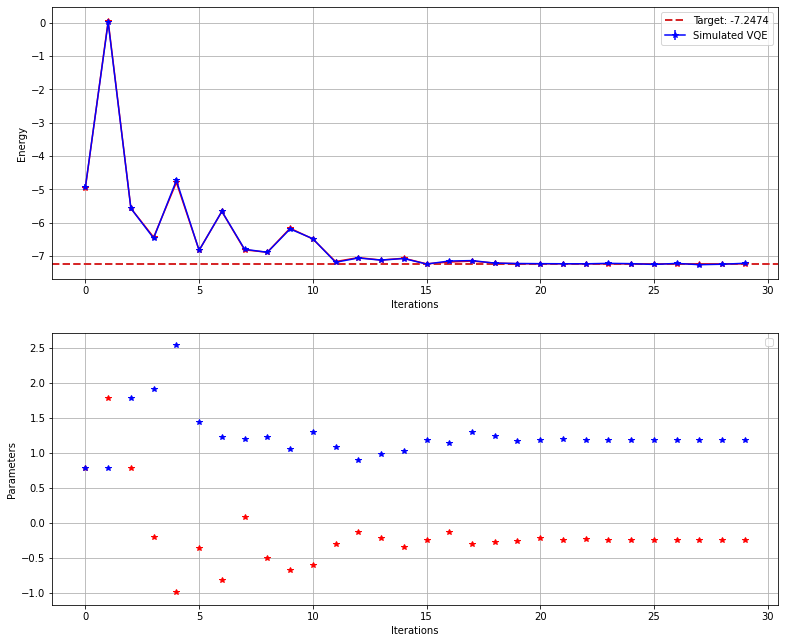

In [14]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)
# Define instance of qiskit-terra's Estimator primitive
estimator = Sampler()


# Setup VQE algorithm
custom_vqe = Miti_CustomVQE(estimator,ansatz,cobyla,level_miti=0,callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(H)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')
energies_miti=[]
errors=[]
energies_ideal=[]
parameters=[]
for data in intermediate_info:
  energies_miti.append(data[0])
  errors.append(data[1])
  energies_ideal.append(data[2])
  parameters.append(data[3])

plt.figure(figsize=(13,11))
plt.subplot(211)
plt.errorbar(np.arange(len(energies_miti)),energies_miti,errors, color='blue',linestyle='-',marker='*' , label='Simulated VQE')
plt.plot(energies_ideal,color='red',marker='*')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()

plt.subplot(212)
colors=['red','blue','black']
for i,para in enumerate(parameters):
  plt.plot(i,para[0],color=colors[0],marker='*')
  plt.plot(i,para[1],color=colors[1],marker='*')
  #plt.plot(i,para[2],color=colors[2],marker='*')
plt.legend()
plt.grid()
plt.ylabel('Parameters')
plt.xlabel('Iterations')
plt.show()

In [15]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="c0df7c866f628346a4ad9eb0955b0b9e8ffedc7dc25fa33a87a59e50864c059fa00f211c7f611efee085a4b810646179209cc819b26a4903c733466bb8b96f51",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = 'ibmq_guadalupe'
noisy_backend = service.get_backend(backend)
backend_noise_model = NoiseModel.from_backend(noisy_backend)
simulator = service.get_backend('ibmq_qasm_simulator')
options = Options()
options.resilience_level = 0
options.optimization_level = 3
options.initial_layout=[1,2]

In [ ]:
# Define a simple callback function
intermediate_info_real_backend_0= []
def callback(value):
        intermediate_info_real_backend_0.append(value)



# Define a simple callback function

'''
options.simulator = {
    "noise_model": backend_noise_model
}
'''
options.shots=10000
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeSampler(session=session,options=options)

    # Setup VQE algorithm
    custom_vqe = Miti_CustomVQE(rt_estimator,ansatz,cobyla,level_miti=0,callback=callback)

    # Run the custom VQE function and monitor execution time
    start = time()
    result = custom_vqe.compute_minimum_eigenvalue(H)
    end = time()
print(result)
print(f'execution time (s): {end - start:.2f}')



ERROR:websocket:Connection to remote host was lost. - goodbye
ERROR:websocket:Connection to remote host was lost. - goodbye
ERROR:websocket:Connection to remote host was lost. - goodbye
